In [1]:
'''
    Setup the project
'''
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install seaborn

ALL_FLAGS = ['ENABLE_PHASE_TIMING', 'ENABLE_DEBUG', 'ENABLE_RANDOM_SAMPLING', 'ENABLE_NORMAL']
# Make directory build if it doesn't exist
!mkdir -p build
!cd build && cmake .. -DENABLE_PHASE_TIMING=OFF -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=OFF && make

     |████████████████████████████████| 11.8 MB 16.9 MB/s eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.4-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached Pillow-9.2.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.2 MB)
  Using cached fonttools-4.37.4-py3-none-any.whl (960 kB)
  Using cached contourpy-1.0.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (296 kB)
  Using cached numpy-1.23.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pandas-1.5.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached pytz-2022.4-py2.py3-none-any.whl (500 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.12.0-py3-none-any.whl (285 kB)
Note: you may need to restart the kernel to use 

In [4]:
# Install the python packages
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Experiments for PSRS

In [45]:
# Helper functions for running the experiments

def runProgram(numElements, seed, useUniprocessor, numThreads=1):
    '''
        Runs the program and capture the results
        The command to run is `cd build && ./main {numThreads} {numElements} {seed} {useUniprocessor}`` which outputs
        ['p: numThreads n: numElements seed: seed useUniprocessor: useUniprocessor', 'time', 'Success'] where time is in nanoseconds
    '''
    sys.stdout.flush()
    result = !cd build && ./main {numThreads} {numElements} {seed} {useUniprocessor}
    try:
        assert result[-1] == 'Success', 'Experiment failed'
    except:
        print('Error in running the program')
        print(result)
        print('Trying again')
        result = !cd build && ./main {numThreads} {numElements} {seed} {useUniprocessor}
        assert result[-1] == 'Success', 'Experiment failed'
        
    return result

def collectData(numElements, seed, useUniprocessor, times=7, numThreads=1):
    '''
        Collects the time data by running the program multiple times with different seeds but same number of elements
    '''
    data = []
    for i in range(times):
        newSeed = seed+(i+1)*20
        print(f'Running program {i+1}/{times} for numElements={numElements} seed={newSeed} useUniprocessor={useUniprocessor} numThreads={numThreads}')
        result = runProgram(numElements, newSeed, useUniprocessor, numThreads)
        data.append(result)
    return data
    
def collectTimingData(numElements, seed, numThreads, lastRuns=5, times=7):
    '''
        Collects the timing data by running collectData for all threads and then averaging the last 5 runs
    '''
    print(f'Collecting timing data for numElements={numElements} seed={seed} maxThreads={numThreads}')
    assert lastRuns <= times, 'lastRuns should be less than or equal to times'
    data = []
    time_uniprocessor = [int(x[1]) for x in collectData(numElements, seed, 1, times)]
    data.append((1, sum(time_uniprocessor[-lastRuns:])/lastRuns))
    for i in range(2, numThreads+1):
        time = [int(x[1]) for x in collectData(numElements, seed, 0, times, i)]
        # take avg of last x runs
        avg = sum(time[-lastRuns:])/lastRuns
        data.append([i, avg])
    return data
def collectPhaseTimingData(numElements, seed, numThreads, lastRuns=5, times=7):
    '''
        Collects the phase timing data by running collectData for all threads and then averaging the last 5 runs for each phase
    '''
    print(f'Collecting phase timing data for numElements={numElements} seed={seed} maxThreads={numThreads}')
    assert lastRuns <= times, 'lastRuns should be less than or equal to times'
    data = []
    for i in range(2, numThreads+1):
        result = collectData(numElements, seed, 0, times, i)
        # std::cout << "Thread: " + std::to_string(threadId) + " Phase: " + std::to_string(phase) + " time: " + std::to_string(std::chrono::duration_cast<std::chrono::nanoseconds>(endPhaseTime - beginPhaseTime).count()) + "\n";
        phase1 = []
        phase2 = []
        phase3 = []
        phase4 = []
        for run in result:
            for r in run:
                if 'Phase: 1' in r:
                    phase1.append(int(r.split(' ')[-1]))
                elif 'Phase: 2' in r:
                    phase2.append(int(r.split(' ')[-1]))
                elif 'Phase: 3' in r:
                    phase3.append(int(r.split(' ')[-1]))
                elif 'Phase: 4' in r:
                    phase4.append(int(r.split(' ')[-1]))
        assert len(phase1) == len(phase2) == len(phase3) == len(phase4), 'Phase data is not collected properly'
        df = pd.DataFrame({'phase1': phase1, 'phase2': phase2, 'phase3': phase3, 'phase4': phase4})
        # Get the average of the last 5 runs
        df = df.iloc[-lastRuns:]
        df = df.mean()
        data.append([i, df['phase1'], df['phase2'], df['phase3'], df['phase4']])
    
    return data
    
    
def writeToCSV(filename, data, header):
    '''
        Writes the data to a csv file
    '''
    df = pd.DataFrame(data, columns=header)
    df.to_csv(filename, index=False)
    print(f'Wrote data to {filename}')

def saveTimingData(experiment_data, id, numElements):
    writeToCSV(f'experiment_{id}_{numElements}.csv', experiment_data, ['numThreads', 'time'])
    experiment_speedup = list(map(lambda x: (x[0], experiment_data[0][1]/x[1]), experiment_data))
    writeToCSV(f'experiment_{id}_{numElements}_speedup.csv', experiment_speedup, ['numThreads', 'speedup'])

def savePhaseTimingData(experiment_data, id, numElements):
    writeToCSV(f'experiment_{id}_{numElements}.csv', experiment_data, ['numThreads', 'phase1', 'phase2', 'phase3', 'phase4'])
    

def runAndSaveExperiment(numElements, seed, threads, id, collect, save):
    print(f'Running experiment id: {id}')
    experiment_data = collect(numElements, seed, threads)
    save(experiment_data, id, numElements)
    
def getPerfExperimentSettings():
    MAX_THREADS = 16
    seed = 100
    numElements = 10000000
    NUM_ELEMENTS_MULTIPLIER = 2
    experiment_settings = []
    SEED_STEP = 13
    NUM_EXPERIMENTS = 8
    for i in range(1, NUM_EXPERIMENTS):
        experiment_settings.append((numElements, seed, MAX_THREADS, f"perf_{i}"))
        numElements = numElements * NUM_ELEMENTS_MULTIPLIER
        seed = seed + SEED_STEP
    return experiment_settings

def getPhaseTimingExperimentSettings():
    experiment_settings = []
    numElements = 100000000
    NUM_ELEMENTS_MULTIPLIER = 2
    MAX_THREADS = 16
    seed = 200
    SEED_STEP = 13
    for i in range(1, 4):
        experiment_settings.append((numElements, seed, MAX_THREADS, f"phase_timing_{i}"))
        numElements = numElements * NUM_ELEMENTS_MULTIPLIER
        seed = seed + SEED_STEP
        
    return experiment_settings

def getRegularVsRandomExperimentSettings(reg=True):
    MAX_THREADS = 8
    seed = 100
    numElements = 10000000
    NUM_ELEMENTS_MULTIPLIER = 1.5
    experiment_settings = []
    SEED_STEP = 13
    NUM_EXPERIMENTS = 4
    for i in range(1, NUM_EXPERIMENTS+1):
        experiment_settings.append((numElements, seed, MAX_THREADS, f"{'regular' if reg else 'random'}_{i}"))
        numElements = int(numElements * NUM_ELEMENTS_MULTIPLIER)
        seed = seed + SEED_STEP
    return experiment_settings

def getUniformVsNormalExperimentSettings(uni=True):
    MAX_THREADS = 8
    seed = 100
    numElements = 10000000
    NUM_ELEMENTS_MULTIPLIER = 1.5
    experiment_settings = []
    SEED_STEP = 13
    NUM_EXPERIMENTS = 4
    for i in range(1, NUM_EXPERIMENTS+1):
        experiment_settings.append((numElements, seed, MAX_THREADS, f"{'uniform' if uni else 'normal'}_{i}"))
        numElements = int(numElements * NUM_ELEMENTS_MULTIPLIER)
        seed = seed + SEED_STEP
    return experiment_settings

    
def validateResult(res):
    generated = res[2].strip().split(' ') # The generated unsorted array
    generated = list(map(lambda x: int(x), generated))
    threads = list(map( lambda x: x.strip().split(" ") ,filter(lambda x: 'Phase:' not in x, res[3:-3])))
    threads = sorted(threads, key=lambda x: int(x[0].split(":")[1])) # Sorting the threads by their id
    threads = list(map(lambda x: list(map(lambda y: int(y), x[1:])), threads)) # Converting the strings to integers
    combined = []
    for t in threads:
        combined.extend(t) # Combining all the threads lists into one
    assert len(generated) == len(combined), 'Generated and combined arrays are not of same length'
    assert sorted(generated) == sorted(combined), 'Generated and combined arrays are not equal'
    print('Validation successful')

def runPerformanceExperiments():
    '''
        These experiments run PSRS on different number of threads and different number of elements. While keeping the seeds constant
    '''
    # Recompiling the program with all flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=OFF -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=OFF && make
    experiment_settings = getPerfExperimentSettings()
    for experiment in experiment_settings:
        runAndSaveExperiment(*experiment, collectTimingData, saveTimingData)
        
def runPhaseTimingExperiments():
    '''
        These experiments run PSRS on different number of threads with a fixed number of elements and seeds.The purpose is to measure the time taken by each phase.
    '''
    # Recompiling the program with the flag ENABLE_PHASE_TIMING and all other flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=ON -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=OFF && make
    experiment_settings = getPhaseTimingExperimentSettings()
    for experiment in experiment_settings:
        runAndSaveExperiment(*experiment, collectPhaseTimingData, savePhaseTimingData)

def runCorrectnessExperiments():
    '''
        These experiments run PSRS on small number of elements and seeds to check the correctness of the implementation. The number of threads is also varied.
    '''
    # Recompiling the program with the flag ENABLE_PHASE_TIMING and all other flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=ON -DENABLE_DEBUG=ON -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=OFF && make
    
    res = runProgram(100, 100, 0, 3)
    validateResult(res)
    res = runProgram(13001, 1300, 0, 5)
    validateResult(res)
    res = runProgram(1020, 1020, 0, 4)
    validateResult(res)
    
def runRegularVsRandomSamplingExperiments():
    '''
        These experiments run PSRS with regular sampling and random sampling on different number of elements and seeds, while keeping the number of threads constant.
    '''
    experiment_settings = getRegularVsRandomExperimentSettings()
    # First run the experiments with regular sampling
    # Recompiling the program with all flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=OFF -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=OFF && make
    for experiment in experiment_settings:
        runAndSaveExperiment(*experiment, collectTimingData, saveTimingData)
        
    experiment_settings = getRegularVsRandomExperimentSettings(reg=False)
    # Then run the experiments with random sampling
    # Recompiling the program with the flag ENABLE_RANDOM_SAMPLING and all other flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=OFF -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=ON -DENABLE_NORMAL=OFF && make
    for experiment in experiment_settings:
        runAndSaveExperiment(*experiment, collectTimingData, saveTimingData)

def runNormalVsUniformExperiments():
    '''
        These experiments run PSRS with normal distribution and uniform distribution on different number of elements and seeds, while keeping the number of threads constant.
    '''
    experiment_settings = getUniformVsNormalExperimentSettings()
    # First run the experiments with uniform distribution
    # Recompiling the program with all flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=OFF -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=OFF && make
    for experiment in experiment_settings:
        runAndSaveExperiment(*experiment, collectTimingData, saveTimingData)
    experiment_settings = getUniformVsNormalExperimentSettings(uni=False)
    # Then run the experiments with normal distribution
    # Recompiling the program with the flag ENABLE_NORMAL and all other flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=OFF -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=ON && make
    for experiment in experiment_settings:
        runAndSaveExperiment(*experiment, collectTimingData, saveTimingData)
    

In [36]:
runPerformanceExperiments()

Running experiment 1 for numElements=10000000 seed=100 maxThreads=16
Running program 1/7 for numElements=10000000 seed=120 useUniprocessor=1 numThreads=1
Running program 2/7 for numElements=10000000 seed=140 useUniprocessor=1 numThreads=1
Running program 3/7 for numElements=10000000 seed=160 useUniprocessor=1 numThreads=1
Running program 4/7 for numElements=10000000 seed=180 useUniprocessor=1 numThreads=1
Running program 5/7 for numElements=10000000 seed=200 useUniprocessor=1 numThreads=1
Running program 6/7 for numElements=10000000 seed=220 useUniprocessor=1 numThreads=1
Running program 7/7 for numElements=10000000 seed=240 useUniprocessor=1 numThreads=1
Running program 1/7 for numElements=10000000 seed=120 useUniprocessor=0 numThreads=2
Running program 2/7 for numElements=10000000 seed=140 useUniprocessor=0 numThreads=2
Running program 3/7 for numElements=10000000 seed=160 useUniprocessor=0 numThreads=2
Running program 4/7 for numElements=10000000 seed=180 useUniprocessor=0 numThread

In [46]:
runPhaseTimingExperiments()

-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
-- IPO is supported
-- Configuring done
-- Generating done
-- Build files have been written to: /home/qasimkhawaja/PSRS/build
[ 20%] Built target engine
[ 60%] Built target main
[100%] Built target unit_tests
Running experiment id: phase_timing_1
Running program 1/7 for numElements=1000000 seed=220 useUniprocessor=0 numThreads=2
Running program 2/7 for numElements=1000000 seed=240 useUniprocessor=0 numThreads=2
Running program 3/7 for numElements=1000000 seed=260 useUniprocessor=0 numThreads=2
Running program 4/7 for numElements=1000000 seed=280 useUniprocessor=0 numThreads=2
Running program 5/7 for numElements=1000000 seed=300 useUniprocessor=0 numThreads=2
Running program 6/7 for numElements=1000000 seed=320 useUniprocessor=0 numThreads=2
Running program 7/7 for numElements=1000000 seed=340 useUniprocessor=0 numThreads=2
Running program 1/7 for numElements=1000000 seed=220 useUniprocessor=0 numThreads=3
Running program 2/7 for 

In [37]:
runCorrectnessExperiments()

-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
-- IPO is supported
-- Configuring done
-- Generating done
-- Build files have been written to: /home/qasimkhawaja/PSRS/build
[ 20%] Built target engine
[ 60%] Built target main
[100%] Built target unit_tests
Validation successful
Validation successful
Validation successful


In [40]:
runRegularVsRandomSamplingExperiments()

-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
-- IPO is supported
-- Configuring done
-- Generating done
-- Build files have been written to: /home/qasimkhawaja/PSRS/build
Scanning dependencies of target engine
[ 20%] Building CXX object CMakeFiles/engine.dir/src/utils.cpp.o
[ 20%] Built target engine
Scanning dependencies of target main
[ 40%] Building CXX object CMakeFiles/main.dir/app/main.cpp.o
[ 60%] Linking CXX executable main
[ 60%] Built target main
Scanning dependencies of target unit_tests
[ 80%] Building CXX object tests/CMakeFiles/unit_tests.dir/main.cpp.o
[100%] Linking CXX executable ../unit_tests
[100%] Built target unit_tests
Running experiment id: regular_1
Running program 1/7 for numElements=10000000 seed=120 useUniprocessor=1 numThreads=1
Running program 2/7 for numElements=10000000 seed=140 useUniprocessor=1 numThreads=1
Running program 3/7 for numElements=10000000 seed=160 useUniprocessor=1 numThreads=1
Running program 4/7 for numElements=10000000 seed=1

In [42]:
runNormalVsUniformExperiments()

-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
-- IPO is supported
-- Configuring done
-- Generating done
-- Build files have been written to: /home/qasimkhawaja/PSRS/build
Scanning dependencies of target engine
[ 20%] Building CXX object CMakeFiles/engine.dir/src/utils.cpp.o
[ 20%] Built target engine
Scanning dependencies of target main
[ 40%] Building CXX object CMakeFiles/main.dir/app/main.cpp.o
[ 60%] Linking CXX executable main
[ 60%] Built target main
Scanning dependencies of target unit_tests
[ 80%] Building CXX object tests/CMakeFiles/unit_tests.dir/main.cpp.o
[100%] Linking CXX executable ../unit_tests
[100%] Built target unit_tests
Running experiment id: uniform_1
Running program 1/7 for numElements=10000000 seed=120 useUniprocessor=1 numThreads=1
Running program 2/7 for numElements=10000000 seed=140 useUniprocessor=1 numThreads=1
Running program 3/7 for numElements=10000000 seed=160 useUniprocessor=1 numThreads=1
Running program 4/7 for numElements=10000000 seed=1

In [11]:
# Helper functions for plotting the results
def plot(experiments, title, xlabel, ylabel, filename, header):
    '''
        Plots the experiments
    '''
    plt.figure(figsize=(10, 10))
    for experiment in experiments:
        df = pd.read_csv(experiment)
        plt.plot(*[df[col] for col in header], label=experiment)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    # plt.savefig(filename)

def plotPhaseTiming(experiments, title, xlabel, ylabel, filename, header):
    '''
        Plots the experiments
    '''
    plt.figure(figsize=(10, 10))
    # Format of the header is [numThreads, phase1, phase2, phase3, phase4]
    for experiment in experiments:
        for i in range(1, 5):
            df = pd.read_csv(experiment)
            plt.plot(df[header[0]], df[header[i]], label=f"{experiment}_phase{i}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(filename)


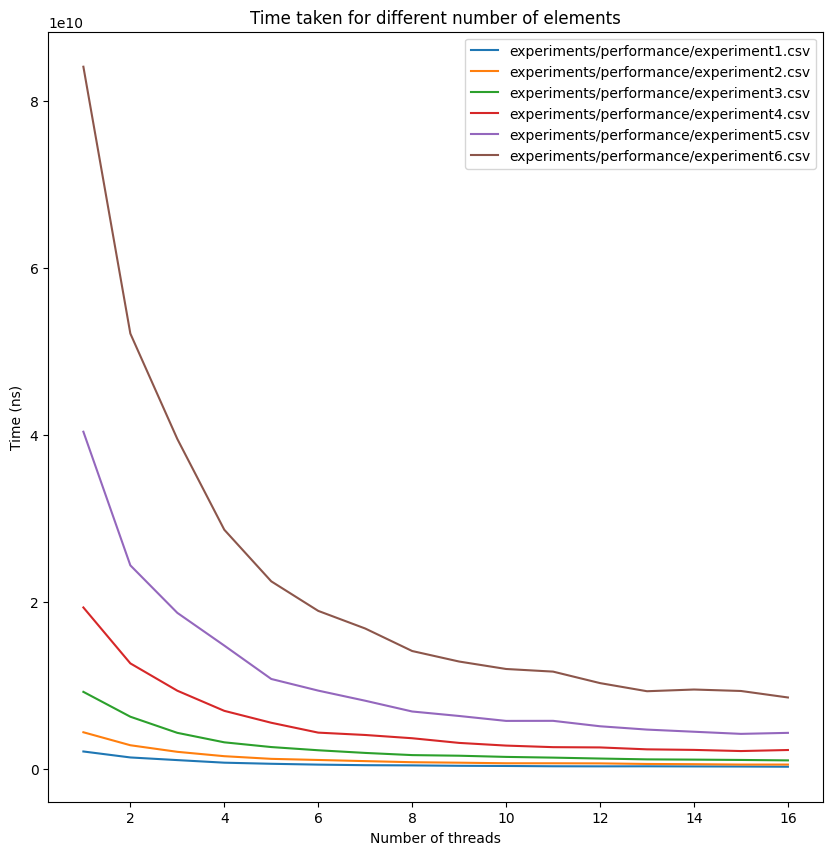

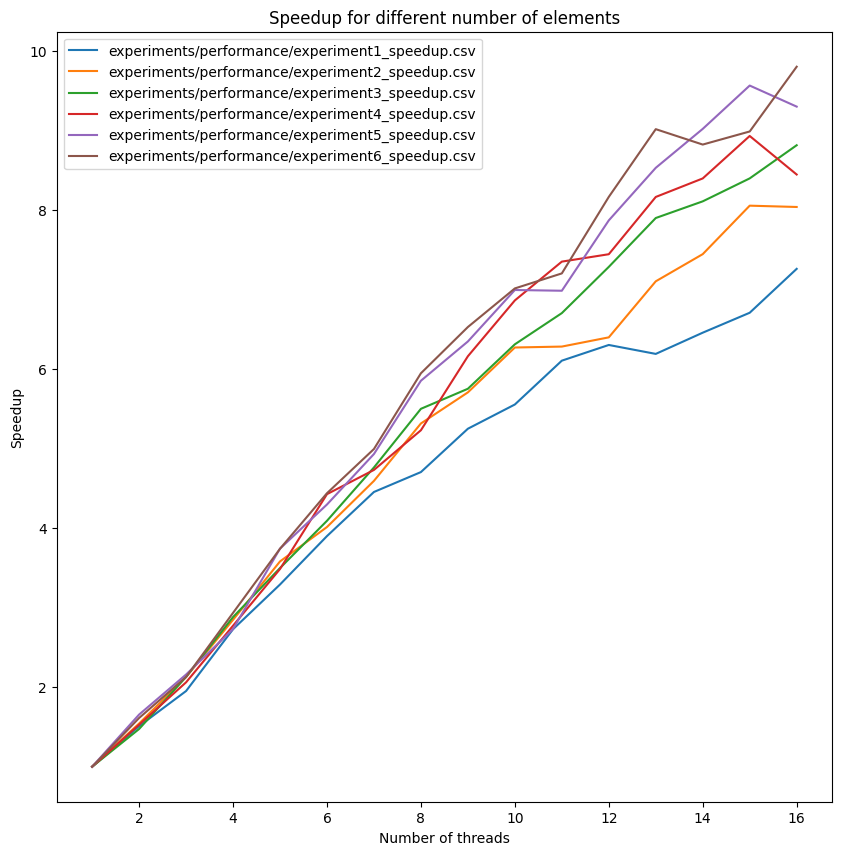

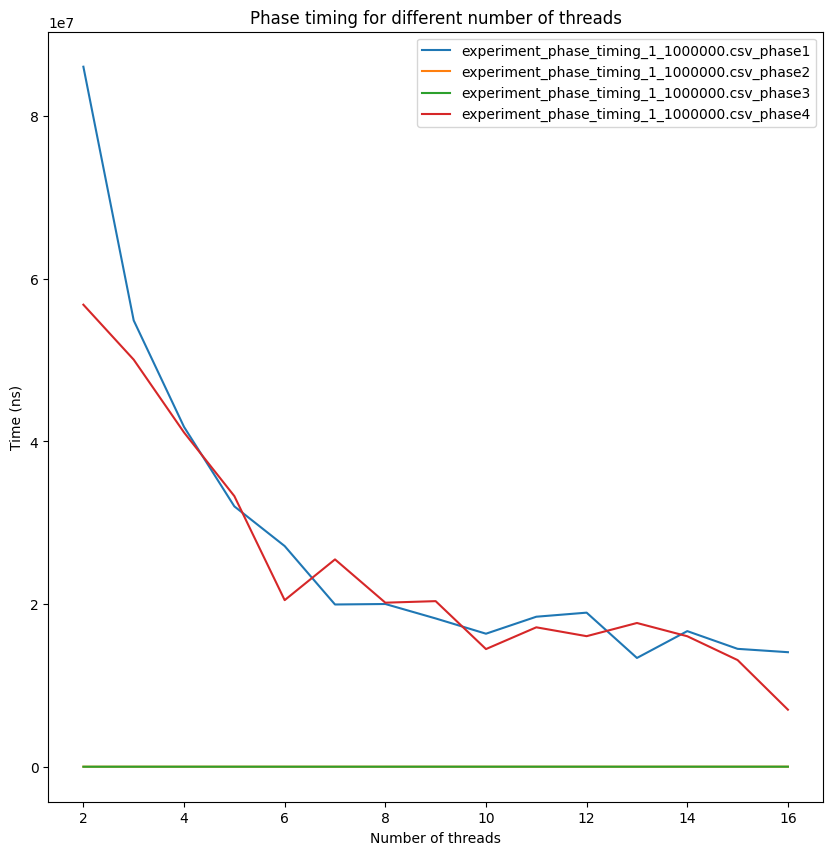

In [12]:
times_files = [f"experiments/performance/experiment{i}.csv" for i in range(1, 7)]
speedup_files = [f"experiments/performance/experiment{i}_speedup.csv" for i in range(1, 7)]
plot(times_files, 'Time taken for different number of elements', 'Number of threads', 'Time (ns)', 'time.png', ['numThreads', 'time'])
plot(speedup_files, 'Speedup for different number of elements', 'Number of threads', 'Speedup', 'speedup.png', ['numThreads', 'speedup'])
phase_files = ["experiment_phase_timing_1_1000000.csv"]
plotPhaseTiming(phase_files, 'Phase timing for different number of threads', 'Number of threads', 'Time (ns)', 'phase_timing.png', ['numThreads', 'phase1', 'phase2', 'phase3', 'phase4'])
